In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

import numpy as np
from pythtb import *
from wpythtb import Bloch, K_mesh, Wannier
from models import kane_mele
import matplotlib.pyplot as plt

/Users/treycole/Repos/WanPy/dev


In [26]:
def get_kane_mele(topological):
    "Return a Kane-Mele model in the normal or topological phase."

    # define lattice vectors
    lat=[[1.0,0.0],[0.5,np.sqrt(3.0)/2.0]]
    # define coordinates of orbitals
    orb=[[1./3.,1./3.],[2./3.,2./3.]]

    # make two dimensional tight-binding Kane-Mele model
    ret_model = tb_model(2,2,lat,orb,nspin=2)

    
    # set other parameters of the model
    thop=1.0
    spin_orb=0.6*thop*0.5
    rashba=0.25*thop
    
    # set model parameters depending on whether you are in the topological
    # phase or not
    if topological=="even":
        esite=2.5
    elif topological=="odd":
        # esite=1.0 
        esite=np.sqrt(3)*3*spin_orb


    # set on-site energies
    ret_model.set_onsite([esite, (-1.0)*esite])

    # set hoppings (one for each connected pair of orbitals)
    # (amplitude, i, j, [lattice vector to cell containing j])

    # useful definitions
    sigma_x=np.array([0.,1.,0.,0])
    sigma_y=np.array([0.,0.,1.,0])
    sigma_z=np.array([0.,0.,0.,1])

    # spin-independent first-neighbor hoppings
    ret_model.set_hop(thop, 0, 1, [ 0, 0])
    ret_model.set_hop(thop, 0, 1, [ 0,-1])
    ret_model.set_hop(thop, 0, 1, [-1, 0])

    # second-neighbour spin-orbit hoppings (s_z)
    ret_model.set_hop(-1.j*spin_orb*sigma_z, 0, 0, [ 0, 1])
    ret_model.set_hop( 1.j*spin_orb*sigma_z, 0, 0, [ 1, 0])
    ret_model.set_hop(-1.j*spin_orb*sigma_z, 0, 0, [ 1,-1])
    ret_model.set_hop( 1.j*spin_orb*sigma_z, 1, 1, [ 0, 1])
    ret_model.set_hop(-1.j*spin_orb*sigma_z, 1, 1, [ 1, 0])
    ret_model.set_hop( 1.j*spin_orb*sigma_z, 1, 1, [ 1,-1])

    # Rashba first-neighbor hoppings: (s_x)(dy)-(s_y)(d_x)
    r3h =np.sqrt(3.0)/2.0
    # bond unit vectors are (r3h,half) then (0,-1) then (-r3h,half)
    ret_model.set_hop(1.j*rashba*( 0.5*sigma_x-r3h*sigma_y), 0, 1, [ 0, 0], mode="add")
    ret_model.set_hop(1.j*rashba*(-1.0*sigma_x            ), 0, 1, [ 0,-1], mode="add")
    ret_model.set_hop(1.j*rashba*( 0.5*sigma_x+r3h*sigma_y), 0, 1, [-1, 0], mode="add")

    return ret_model

In [ ]:
# if topological=="even":
#     onsite=2.5
#   elif topological=="odd":
#     onsite=1.0

t = 1
soc = 0.6*t*0.5
# soc = 0.6*t*0.5
# rashba = 0.25*t
rashba = 0.25*t
onsite = np.sqrt( (3*np.sqrt(3)*soc)**2 - 4*rashba**2 )

# km_model = kane_mele(onsite, t, soc, rashba)
n_supercell = 2
km_model = kane_mele(onsite, t, soc, rashba).make_supercell([[n_supercell, 0], [0, n_supercell]])
orb_vecs = km_model.get_orb_vecs()
n_orb = km_model.get_num_orbitals()
n_occ = int(n_orb/2)*2
low_E_sites = list(np.arange(0, n_orb, 2))

(<Figure size 640x480 with 2 Axes>, <Axes: ylabel='Energy $E(\\mathbf{{k}})$'>)

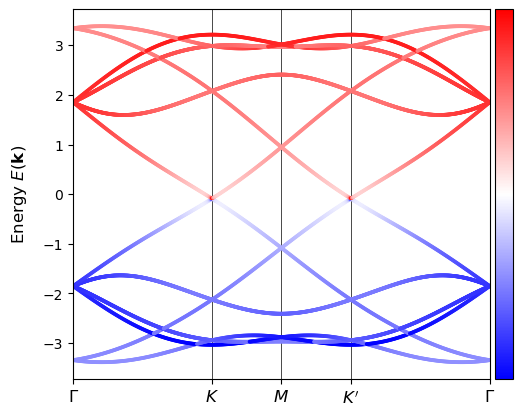

In [42]:
path = [[0.,0.],[2./3.,1./3.],[.5,.5],[1./3.,2./3.], [0.,0.]]
label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $')
km_model.plot_bands(path, k_label=label, nk=501, proj_orb_idx=low_E_sites)

In [27]:
my_model = get_kane_mele("odd").make_supercell([[n_supercell, 0], [0, n_supercell]])

Text(0, 0.5, 'Energy')

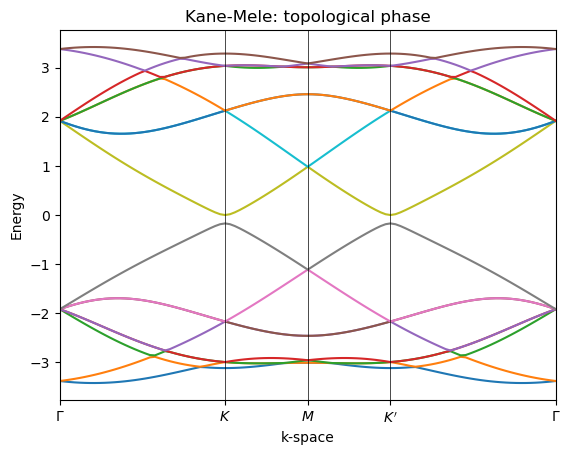

In [28]:
(k_vec, k_dist, k_node) = my_model.k_path(path,101,report=False)
evals = my_model.solve_all(k_vec)

fig, ax = plt.subplots()

for n in range(evals.shape[0]):
    ax.plot(k_dist, evals[n])

ax.set_title("Kane-Mele: topological phase")
ax.set_xticks(k_node)
ax.set_xticklabels(label)
ax.set_xlim(k_node[0],k_node[-1])
for n in range(len(k_node)):
    ax.axvline(x=k_node[n],linewidth=0.5, color='k')
ax.set_xlabel("k-space")
ax.set_ylabel("Energy")

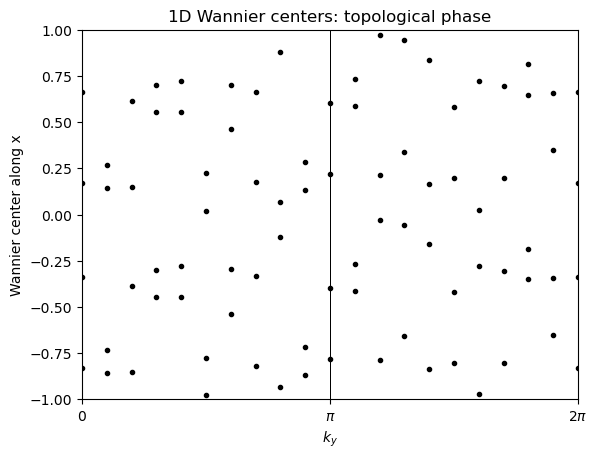

In [22]:
my_array = wf_array(my_model,[21, 21])

my_array.solve_on_grid([0,0])

wan_cent = my_array.berry_phase([0,1], dir=0, contin=False, berry_evals=True)
wan_cent/= 2*np.pi

fig, ax = plt.subplots()
nky = wan_cent.shape[0]
ky = np.linspace(0.,1.,nky)
# draw shifted Wannier center positions
for shift in range(-2,3):
    ax.plot(ky,wan_cent[:,0]+float(shift),"k.")
    ax.plot(ky,wan_cent[:,1]+float(shift),"k.")
    ax.set_ylim(-1.0,1.0)
    ax.set_ylabel('Wannier center along x')
    ax.set_xlabel(r'$k_y$')
    ax.set_xticks([0.0,0.5,1.0])
    ax.set_xlim(0.0,1.0)
    ax.set_xticklabels([r"$0$",r"$\pi$", r"$2\pi$"])
    ax.axvline(x=.5,linewidth=0.5, color='k')
    ax.set_title("1D Wannier centers: topological phase")

In [11]:
bloch_wfs = Bloch(km_model, 20, 20)
bloch_wfs.solve_model()
u_wfs = bloch_wfs.get_states()["Cell periodic"]
# hyb_wan_cent = bloch_wfs.berry_phase(dir=0, evals=True, state_idx=np.arange(2))
# hyb_wan_cent /= 2*np.pi

ky = np.linspace(0., 1., 20)
hyb_wan_cent = np.zeros((ky.shape[0], 2))

G = np.zeros(2)
G[0] = 1
phase = np.exp(-1j * 2 * np.pi * (orb_vecs @ G.T)).T

for idx, k in enumerate(ky):
    u_slice = u_wfs[:, idx, :2, :, :]
    last_state = u_slice[0, ...] * phase[np.newaxis, :, np.newaxis]
    u_slice = np.append(u_slice, last_state[np.newaxis, :, :, :], axis=0)
    b_phase = bloch_wfs.berry_loop(u_slice, evals=True)
    # print(b_phase)
    hyb_wan_cent[idx] = b_phase

hyb_wan_cent /= 2*np.pi

Text(0.5, 1.0, '1D Wannier centers: topological phase')

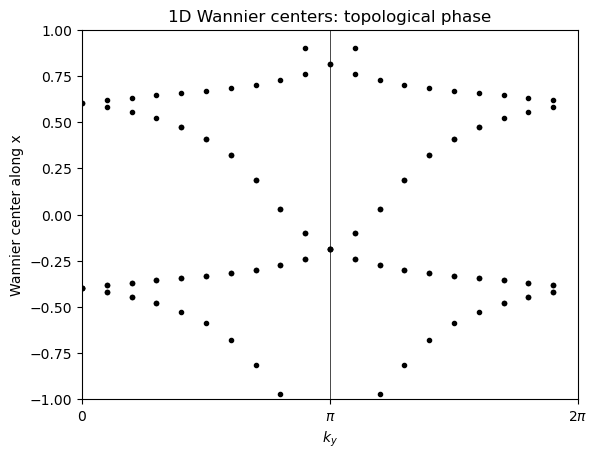

In [12]:
fig, ax = plt.subplots()

nky = hyb_wan_cent.shape[0]
ky = np.linspace(0 , 1, nky, endpoint=False)
# draw shifted Wannier center positions
ax.plot(ky, hyb_wan_cent[:, 0] , "k.")
ax.plot(ky, hyb_wan_cent[:, 1] , "k.")

for shift in range(-2, 3):
    ax.plot(ky, hyb_wan_cent[:, 0] + float(shift), "k.")
    ax.plot(ky, hyb_wan_cent[:, 1] + float(shift), "k.")

ax.set_ylim(-1.0,1.0)
ax.set_ylabel('Wannier center along x')
ax.set_xlabel(r'$k_y$')
ax.set_xticks([0.0,0.5,1.0])
ax.set_xlim(0.0,1.0)
ax.set_xticklabels([r"$0$",r"$\pi$", r"$2\pi$"])
ax.axvline(x=.5,linewidth=0.5, color='k')
ax.set_title("1D Wannier centers: topological phase")

In [23]:
eigvals, eigvecs = km_model.solve_ham(k_vec, return_eigvecs=True)

In [ ]:
eigvecs[1, 0, 5, ]

np.complex128(2.201686844573231e-15-0.2866249304452359j)